In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 169001437/169001437 [00:13<00:00, 12854755.44it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


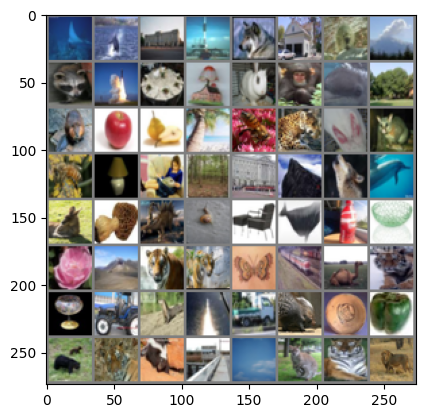

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class NetWithStandardSoftmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_with_standard_softmax = NetWithStandardSoftmax().to(device)


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_with_standard_softmax.parameters(), lr=0.001)

for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net_with_standard_softmax(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:    
            print('[%d, %3d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1, 200] loss: 4.355
[1, 400] loss: 4.023
[1, 600] loss: 3.853
[2, 200] loss: 3.601
[2, 400] loss: 3.512
[2, 600] loss: 3.465
[3, 200] loss: 3.297
[3, 400] loss: 3.287
[3, 600] loss: 3.221
[4, 200] loss: 3.136
[4, 400] loss: 3.124
[4, 600] loss: 3.096
[5, 200] loss: 3.015
[5, 400] loss: 3.006
[5, 600] loss: 3.002
[6, 200] loss: 2.906
[6, 400] loss: 2.923
[6, 600] loss: 2.947
[7, 200] loss: 2.835
[7, 400] loss: 2.823
[7, 600] loss: 2.875
[8, 200] loss: 2.760
[8, 400] loss: 2.789
[8, 600] loss: 2.780
[9, 200] loss: 2.715
[9, 400] loss: 2.711
[9, 600] loss: 2.732
[10, 200] loss: 2.667
[10, 400] loss: 2.676
[10, 600] loss: 2.684
Finished Training


In [7]:
target_list = []
prediction_list = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net_with_standard_softmax(inputs)
        _, predicted = torch.max(outputs.data, 1)
        target_list += labels.cpu().numpy().tolist()
        prediction_list += predicted.cpu().numpy().tolist()

In [8]:
accuracy = accuracy_score(target_list, prediction_list)
precision = precision_score(target_list, prediction_list, average='weighted')
recall = recall_score(target_list, prediction_list, average='weighted')
f1 = f1_score(target_list, prediction_list, average='weighted')
confusion = confusion_matrix(target_list, prediction_list)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("Confusion matrix:\n", confusion)

Accuracy: 0.2783
Precision: 0.2793062058543705
Recall: 0.2783
F1 score: 0.26371471763119725
Confusion matrix:
 [[64  1  0 ...  0  2  1]
 [ 5 31  0 ...  0  0  0]
 [ 2  1 10 ...  0  8  3]
 ...
 [ 0  0  0 ... 20  0  2]
 [ 0  1  2 ...  2 14  0]
 [ 0  0  1 ...  0  0 14]]


In [9]:
class NetWithGumbelSoftmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.gumbel_softmax(x)
        return x

net_with_gumbel_softmax = NetWithGumbelSoftmax().to(device)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_with_gumbel_softmax.parameters(), lr=0.001)

for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net_with_gumbel_softmax(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:  
            print('[%d, %3d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1, 200] loss: 4.604
[1, 400] loss: 4.596
[1, 600] loss: 4.588
[2, 200] loss: 4.581
[2, 400] loss: 4.583
[2, 600] loss: 4.582
[3, 200] loss: 4.570
[3, 400] loss: 4.570
[3, 600] loss: 4.570
[4, 200] loss: 4.564
[4, 400] loss: 4.566
[4, 600] loss: 4.558
[5, 200] loss: 4.559
[5, 400] loss: 4.554
[5, 600] loss: 4.552
[6, 200] loss: 4.555
[6, 400] loss: 4.551
[6, 600] loss: 4.547
[7, 200] loss: 4.544
[7, 400] loss: 4.548
[7, 600] loss: 4.549
[8, 200] loss: 4.547
[8, 400] loss: 4.546
[8, 600] loss: 4.539
[9, 200] loss: 4.539
[9, 400] loss: 4.544
[9, 600] loss: 4.542
[10, 200] loss: 4.538
[10, 400] loss: 4.540
[10, 600] loss: 4.542
Finished Training


In [11]:
target_list = []
prediction_list = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net_with_gumbel_softmax(inputs)
        _, predicted = torch.max(outputs.data, 1)
        target_list += labels.cpu().numpy().tolist()
        prediction_list += predicted.cpu().numpy().tolist()

In [12]:
accuracy = accuracy_score(target_list, prediction_list)
precision = precision_score(target_list, prediction_list, average='weighted')
recall = recall_score(target_list, prediction_list, average='weighted')
f1 = f1_score(target_list, prediction_list, average='weighted')
confusion = confusion_matrix(target_list, prediction_list)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("Confusion matrix:\n", confusion)

Accuracy: 0.0839
Precision: 0.027112427770952716
Recall: 0.0839
F1 score: 0.032874188096008845
Confusion matrix:
 [[ 0  0 14 ...  0  0  0]
 [ 0  0  3 ...  0  0  0]
 [ 0  0 17 ...  0  0  0]
 ...
 [ 0  0  2 ...  0  0  0]
 [ 0  0 16 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
from torch.nn import AdaptiveLogSoftmaxWithLoss

class NetWithAdaptiveSoftmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_with_adaptive_softmax = NetWithAdaptiveSoftmax().to(device)


In [14]:
optimizer = optim.Adam(net_with_adaptive_softmax.parameters(), lr=0.001)
criterion = nn.AdaptiveLogSoftmaxWithLoss(100, 100, cutoffs=[20, 60])
criterion.to(device)

for epoch in range(10):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net_with_adaptive_softmax(inputs)
        outputs, loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:    
          print('[%d, %3d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 200))
          running_loss = 0.0

print('Finished Training')

[1, 200] loss: 4.724
[1, 400] loss: 4.593
[1, 600] loss: 4.481
[2, 200] loss: 4.341
[2, 400] loss: 4.296
[2, 600] loss: 4.261
[3, 200] loss: 4.150
[3, 400] loss: 4.137
[3, 600] loss: 4.096
[4, 200] loss: 4.028
[4, 400] loss: 3.984
[4, 600] loss: 3.956
[5, 200] loss: 3.880
[5, 400] loss: 3.894
[5, 600] loss: 3.890
[6, 200] loss: 3.806
[6, 400] loss: 3.825
[6, 600] loss: 3.782
[7, 200] loss: 3.743
[7, 400] loss: 3.738
[7, 600] loss: 3.725
[8, 200] loss: 3.668
[8, 400] loss: 3.677
[8, 600] loss: 3.667
[9, 200] loss: 3.602
[9, 400] loss: 3.621
[9, 600] loss: 3.630
[10, 200] loss: 3.584
[10, 400] loss: 3.587
[10, 600] loss: 3.564
Finished Training


In [15]:
target_list = []
prediction_list = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net_with_adaptive_softmax(inputs)
        _, predicted = torch.max(outputs.data, 1)
        target_list += labels.cpu().numpy().tolist()
        prediction_list += predicted.cpu().numpy().tolist()

In [16]:
accuracy = accuracy_score(target_list, prediction_list)
precision = precision_score(target_list, prediction_list, average='weighted')
recall = recall_score(target_list, prediction_list, average='weighted')
f1 = f1_score(target_list, prediction_list, average='weighted')
confusion = confusion_matrix(target_list, prediction_list)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("Confusion matrix:\n", confusion)


Accuracy: 0.012
Precision: 0.0035868628895742824
Recall: 0.012
F1 score: 0.004079380414495148
Confusion matrix:
 [[ 0  0 51 ...  1  0  0]
 [ 0  0  1 ...  1  0  0]
 [ 0  0 16 ...  1  0  0]
 ...
 [ 1  0  1 ...  0  0  0]
 [ 0  0 13 ...  0  0  0]
 [ 0  0  7 ...  2  0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
